In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
import calendar
#import prophet
from datetime import datetime
from scipy import stats
import researchpy as rp
from scipy.stats import levene
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings("ignore")
pd.options.display.max_columns = None

plt.rcParams["figure.figsize"] = (10,8)

In [2]:
df = pd.read_csv("data/01_bikes_registrados.csv", index_col = 0 )
df.head()

,registro,fecha,estacion,año,mes,vacaciones,dia_semana,laborable,clima,temperatura,sensacion_termica,humedad,viento,registrados
0,1,2018-01-01,winter,0,1,1,1,NO,2,14.110847,18.18125,80.5833,10.749882,654
1,2,2018-01-02,winter,0,1,0,2,SI,2,14.902598,17.68695,69.6087,16.652113,670
2,3,2018-01-03,winter,0,1,0,3,SI,1,8.050924,9.47025,43.7273,16.636703,1229
3,4,2018-01-04,winter,0,1,0,4,SI,1,8.200000,10.60610,59.0435,10.739832,1454
4,5,2018-01-05,winter,0,1,0,5,SI,1,9.305237,11.46350,43.6957,12.522300,1518


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   registro           730 non-null    int64  
 1   fecha              730 non-null    object 
 2   estacion           730 non-null    object 
 3   año                730 non-null    int64  
 4   mes                730 non-null    int64  
 5   vacaciones         730 non-null    int64  
 6   dia_semana         730 non-null    int64  
 7   laborable          730 non-null    object 
 8   clima              730 non-null    int64  
 9   temperatura        730 non-null    float64
 10  sensacion_termica  730 non-null    float64
 11  humedad            730 non-null    float64
 12  viento             730 non-null    float64
 13  registrados        730 non-null    int64  
dtypes: float64(4), int64(7), object(3)
memory usage: 85.5+ KB


In [4]:
df.shape

(730, 14)

In [5]:
df.duplicated().sum()

0

In [6]:
df.isnull().sum()

registro             0
fecha                0
estacion             0
año                  0
mes                  0
vacaciones           0
dia_semana           0
laborable            0
clima                0
temperatura          0
sensacion_termica    0
humedad              0
viento               0
registrados          0
dtype: int64

In [7]:
df["vacaciones"] = df["vacaciones"].astype("category")

In [8]:
def detectar_outliers(lista_columnas, dataframe):
    dicc_indices = {} # creamos un diccionario donde almacenaremos índices de los outliers
    # iteramos por la lista de las columnas numéricas de nuestro dataframe
    for col in lista_columnas:
        #calculamos los cuartiles Q1 y Q3
        Q1 = np.nanpercentile(df[col], 25)
        Q3 = np.nanpercentile(df[col], 75)
        # calculamos el rango intercuartil
        IQR = Q3 - Q1
        # calculamos los límites
        outlier_step = 1.5 * IQR
        # filtramos nuestro dataframe para indentificar los outliers
        outliers_data = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step)]
        if outliers_data.shape[0] > 0: # chequeamos si nuestro dataframe tiene alguna fila.
            dicc_indices[col] = (list(outliers_data.index)) # si tiene fila es que hay outliers y por lo tanto lo añadimos a nuestro diccionario
    return dicc_indices

In [9]:
numericas = df.select_dtypes(include = np.number)
columnas = numericas.columns

In [10]:
indices = detectar_outliers(columnas, numericas)

In [11]:
out_registrados = indices["viento"]

Detectamos que en viento y humedad tenemos 

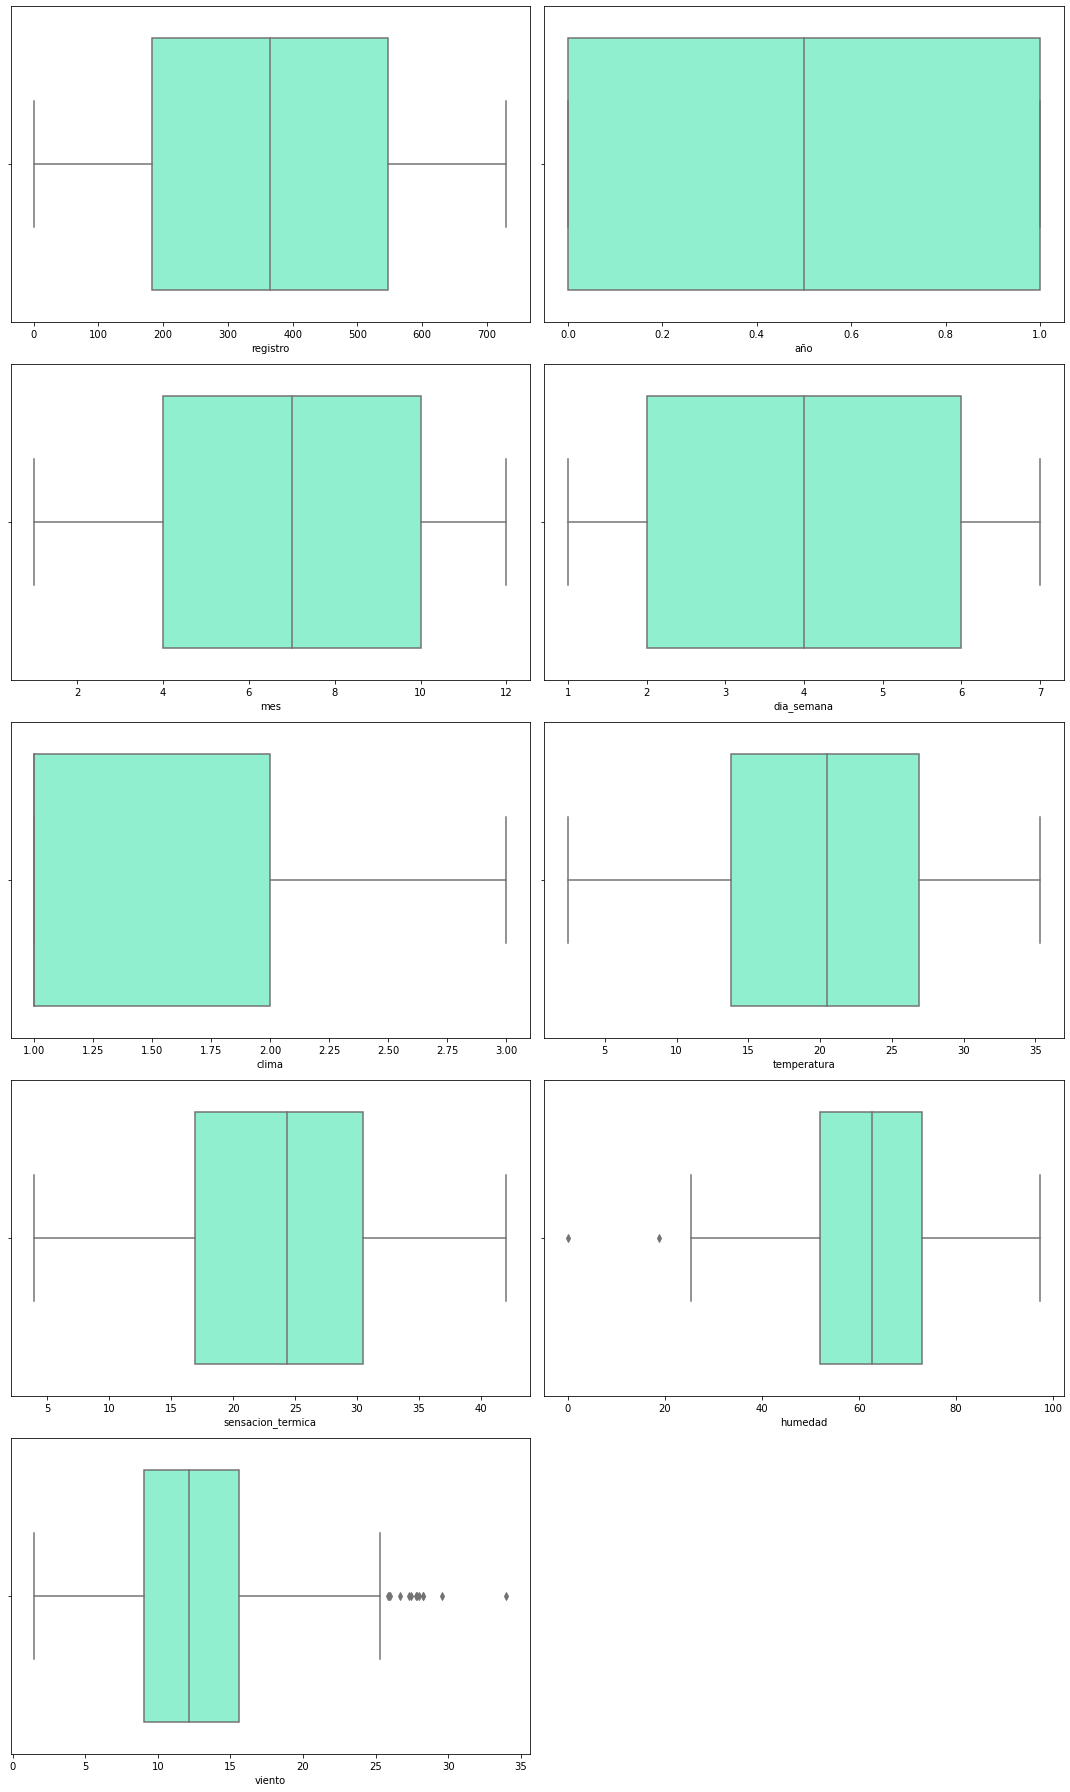

In [12]:
fig, axes = plt.subplots(5, 2, figsize=(15,25))

axes = axes.flat

for indice, columna in enumerate(numericas.columns):
    sns.boxplot(x = numericas[columna], data = df, ax=axes[indice], color = "aquamarine"); # para trazar una línea de densidad

    
plt.tight_layout()
fig.delaxes(axes[-1])
plt.show()


Seria interesante ver que que tienen en común los días en los que los casuales alquilan muchas más bicis

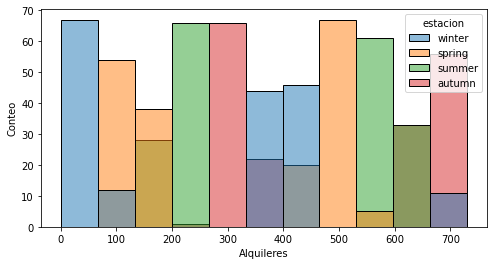

In [13]:
plt.figure(figsize =(8,4))

fig = sns.histplot(x='registro', data = df, hue = 'estacion')

# establecemos el nombre de los ejes, pero recordad que esto no es obligatorio ya que Seaborn nos los genera automaticamente
fig.set(ylabel='Conteo', xlabel = 'Alquileres')

# Ponemos título a  la gráfica
fig.set_title('')

# mostramos la gráfica
plt.show()


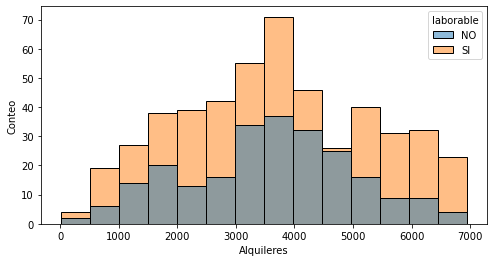

In [14]:
plt.figure(figsize =(8,4))

fig = sns.histplot(x='registrados', data = df, hue = 'laborable')

# establecemos el nombre de los ejes, pero recordad que esto no es obligatorio ya que Seaborn nos los genera automaticamente
fig.set(ylabel='Conteo', xlabel = 'Alquileres')

# Ponemos título a  la gráfica
fig.set_title('')

# mostramos la gráfica
plt.show()

De este grafico podemos ver que los días que más bicis se alquilan son los días laborables. 

In [15]:
df.sample()

,registro,fecha,estacion,año,mes,vacaciones,dia_semana,laborable,clima,temperatura,sensacion_termica,humedad,viento,registrados
308,309,2018-11-05,autumn,0,11,0,1,SI,1,13.393347,16.1927,51.9167,12.667154,2770


__________

Miramos las asunciones

Testeamos la normalidad de la var respuesta

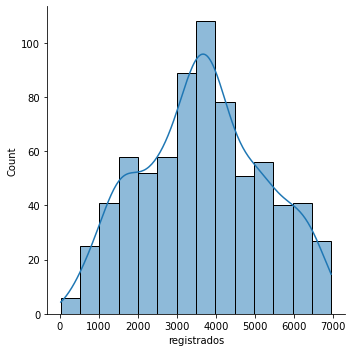

In [16]:
sns.displot(df["registrados"], kde=True)

In [17]:
stats.shapiro(df["registrados"])

ShapiroResult(statistic=0.98438560962677, pvalue=5.023745757171127e-07)

Los datos no son normales porque son menores de 0.05

Procedemos a normalizar la variable respuesta

Raiz cuadrada

In [18]:
import math

In [19]:
df["registrados_raiz"] = df["registrados"].apply(lambda x: math.sqrt(x))

In [20]:
stats.shapiro(df["registrados_raiz"])

ShapiroResult(statistic=0.9734106659889221, pvalue=2.97543378824372e-10)

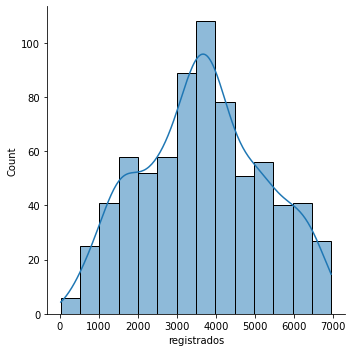

In [21]:
sns.displot(df["registrados"], kde=True)

Box_cox

In [22]:
df['registrados_box'], lambda_ajustada = stats.boxcox(df['registrados'])


In [23]:
stats.shapiro(df["registrados_box"])

ShapiroResult(statistic=0.9854231476783752, pvalue=1.1639369859040016e-06)

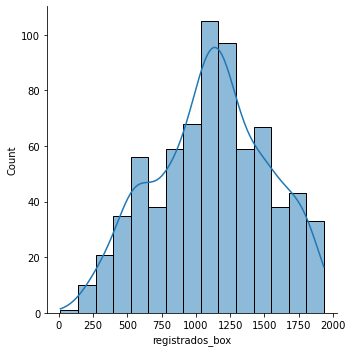

In [24]:
sns.displot(df["registrados_box"], kde=True)

In [25]:
df["registrados_log"] = df["registrados"].apply(lambda x: np.log(x) if x > 0 else 0)

In [26]:
df.head()

,registro,fecha,estacion,año,mes,vacaciones,dia_semana,laborable,clima,temperatura,sensacion_termica,humedad,viento,registrados,registrados_raiz,registrados_box,registrados_log
0,1,2018-01-01,winter,0,1,1,1,NO,2,14.110847,18.18125,80.5833,10.749882,654,25.573424,267.555885,6.483107
1,2,2018-01-02,winter,0,1,0,2,SI,2,14.902598,17.68695,69.6087,16.652113,670,25.884358,273.035135,6.507278
2,3,2018-01-03,winter,0,1,0,3,SI,1,8.050924,9.47025,43.7273,16.636703,1229,35.057096,453.922956,7.113956
3,4,2018-01-04,winter,0,1,0,4,SI,1,8.200000,10.60610,59.0435,10.739832,1454,38.131352,522.514924,7.282074
4,5,2018-01-05,winter,0,1,0,5,SI,1,9.305237,11.46350,43.6957,12.522300,1518,38.961519,541.694947,7.325149


In [27]:
stats.shapiro(df["registrados_log"])

ShapiroResult(statistic=0.8750768303871155, pvalue=9.986205976410893e-24)

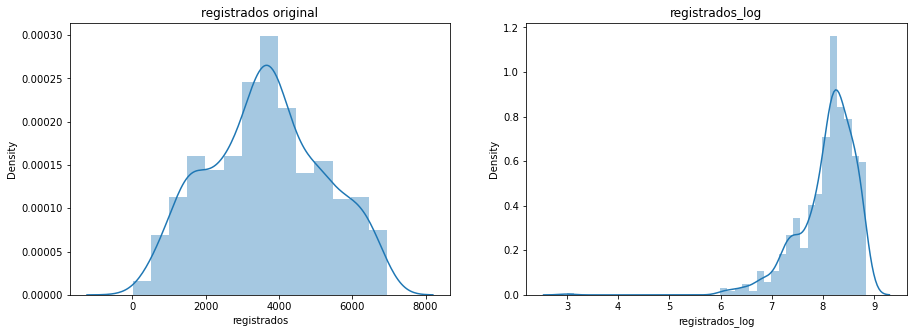

In [28]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('registrados original')
axes[1].set_title('registrados_log')

sns.distplot(df["registrados"] ,ax = axes[0])
sns.distplot(df["registrados_log"], ax = axes[1]);

#### Conclusion:

Observamos que nuestro p_valor > 0.05 nuestros datos NO son normales. 

- Min Scaler

In [29]:
minmax = MinMaxScaler()
minmax.fit(df[['registrados']])

MinMaxScaler()

In [30]:
X_normalizadas = minmax.transform(df[['registrados']])

In [31]:
X_normalizadas.min(axis=0)

array([0.])

In [32]:
X_normalizadas.max(axis=0)

array([1.])

In [33]:
numericas_minmax= pd.DataFrame(X_normalizadas, columns= ['registrados'])
numericas_minmax.head()

,registrados
0,0.091539
1,0.093849
2,0.174560
3,0.207046
4,0.216286


In [34]:
df['registrados_min_max'] = numericas_minmax
df.head()

,registro,fecha,estacion,año,mes,vacaciones,dia_semana,laborable,clima,temperatura,sensacion_termica,humedad,viento,registrados,registrados_raiz,registrados_box,registrados_log,registrados_min_max
0,1,2018-01-01,winter,0,1,1,1,NO,2,14.110847,18.18125,80.5833,10.749882,654,25.573424,267.555885,6.483107,0.091539
1,2,2018-01-02,winter,0,1,0,2,SI,2,14.902598,17.68695,69.6087,16.652113,670,25.884358,273.035135,6.507278,0.093849
2,3,2018-01-03,winter,0,1,0,3,SI,1,8.050924,9.47025,43.7273,16.636703,1229,35.057096,453.922956,7.113956,0.174560
3,4,2018-01-04,winter,0,1,0,4,SI,1,8.200000,10.60610,59.0435,10.739832,1454,38.131352,522.514924,7.282074,0.207046
4,5,2018-01-05,winter,0,1,0,5,SI,1,9.305237,11.46350,43.6957,12.522300,1518,38.961519,541.694947,7.325149,0.216286


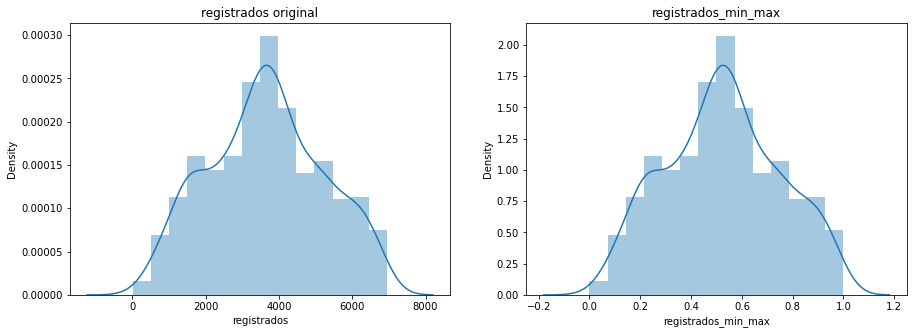

In [35]:

fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('registrados original')
axes[1].set_title('registrados_min_max')

sns.distplot(df['registrados'] ,ax = axes[0])
sns.distplot(df['registrados_min_max'], ax = axes[1]);

In [36]:
stats.shapiro(df["registrados_min_max"])

ShapiroResult(statistic=0.98438560962677, pvalue=5.023745757171127e-07)

#### Conclusiones:

Observamos que nuestro p_valor > 0.05 nuestros datos NO son normales. 

In [37]:
#Borramos las columnas que no necesitamos 
df.drop(['registrados_raiz','registrados_box', 'registrados_log', 'registrados_min_max'], axis=1, inplace=True )

In [38]:
df.head(2)

,registro,fecha,estacion,año,mes,vacaciones,dia_semana,laborable,clima,temperatura,sensacion_termica,humedad,viento,registrados
0,1,2018-01-01,winter,0,1,1,1,NO,2,14.110847,18.18125,80.5833,10.749882,654
1,2,2018-01-02,winter,0,1,0,2,SI,2,14.902598,17.68695,69.6087,16.652113,670


---

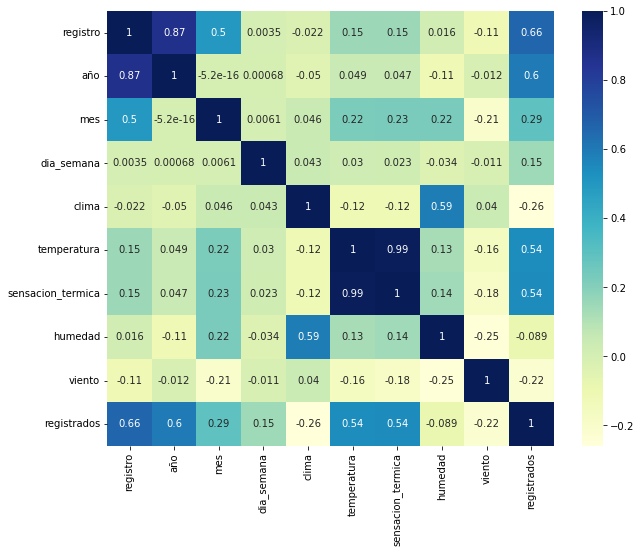

In [39]:
sns.heatmap(df.corr(), 
            cmap = "YlGnBu", 
           annot = True);

In [40]:
df.corr()

,registro,año,mes,dia_semana,clima,temperatura,sensacion_termica,humedad,viento,registrados
registro,1.000000,8.660262e-01,4.982507e-01,0.003548,-0.021862,0.150738,0.152773,0.016080,-0.112667,0.660544
año,0.866026,1.000000e+00,-5.162656e-16,0.000684,-0.050322,0.048789,0.047215,-0.112547,-0.011624,0.596911
mes,0.498251,-5.162656e-16,1.000000e+00,0.006080,0.045613,0.219083,0.226430,0.224937,-0.208013,0.291952
dia_semana,0.003548,6.843499e-04,6.079650e-03,1.000000,0.042703,0.029929,0.023235,-0.034223,-0.011361,0.148473
clima,-0.021862,-5.032247e-02,4.561335e-02,0.042703,1.000000,-0.119503,-0.120559,0.590277,0.039769,-0.259025
temperatura,0.150738,4.878919e-02,2.190833e-01,0.029929,-0.119503,1.000000,0.991696,0.128565,-0.158186,0.539436
sensacion_termica,0.152773,4.721519e-02,2.264302e-01,0.023235,-0.120559,0.991696,1.000000,0.141512,-0.183876,0.543678
humedad,0.016080,-1.125471e-01,2.249368e-01,-0.034223,0.590277,0.128565,0.141512,1.000000,-0.248506,-0.089212
viento,-0.112667,-1.162435e-02,-2.080131e-01,-0.011361,0.039769,-0.158186,-0.183876,-0.248506,1.000000,-0.217914
registrados,0.660544,5.969106e-01,2.919516e-01,0.148473,-0.259025,0.539436,0.543678,-0.089212,-0.217914,1.000000


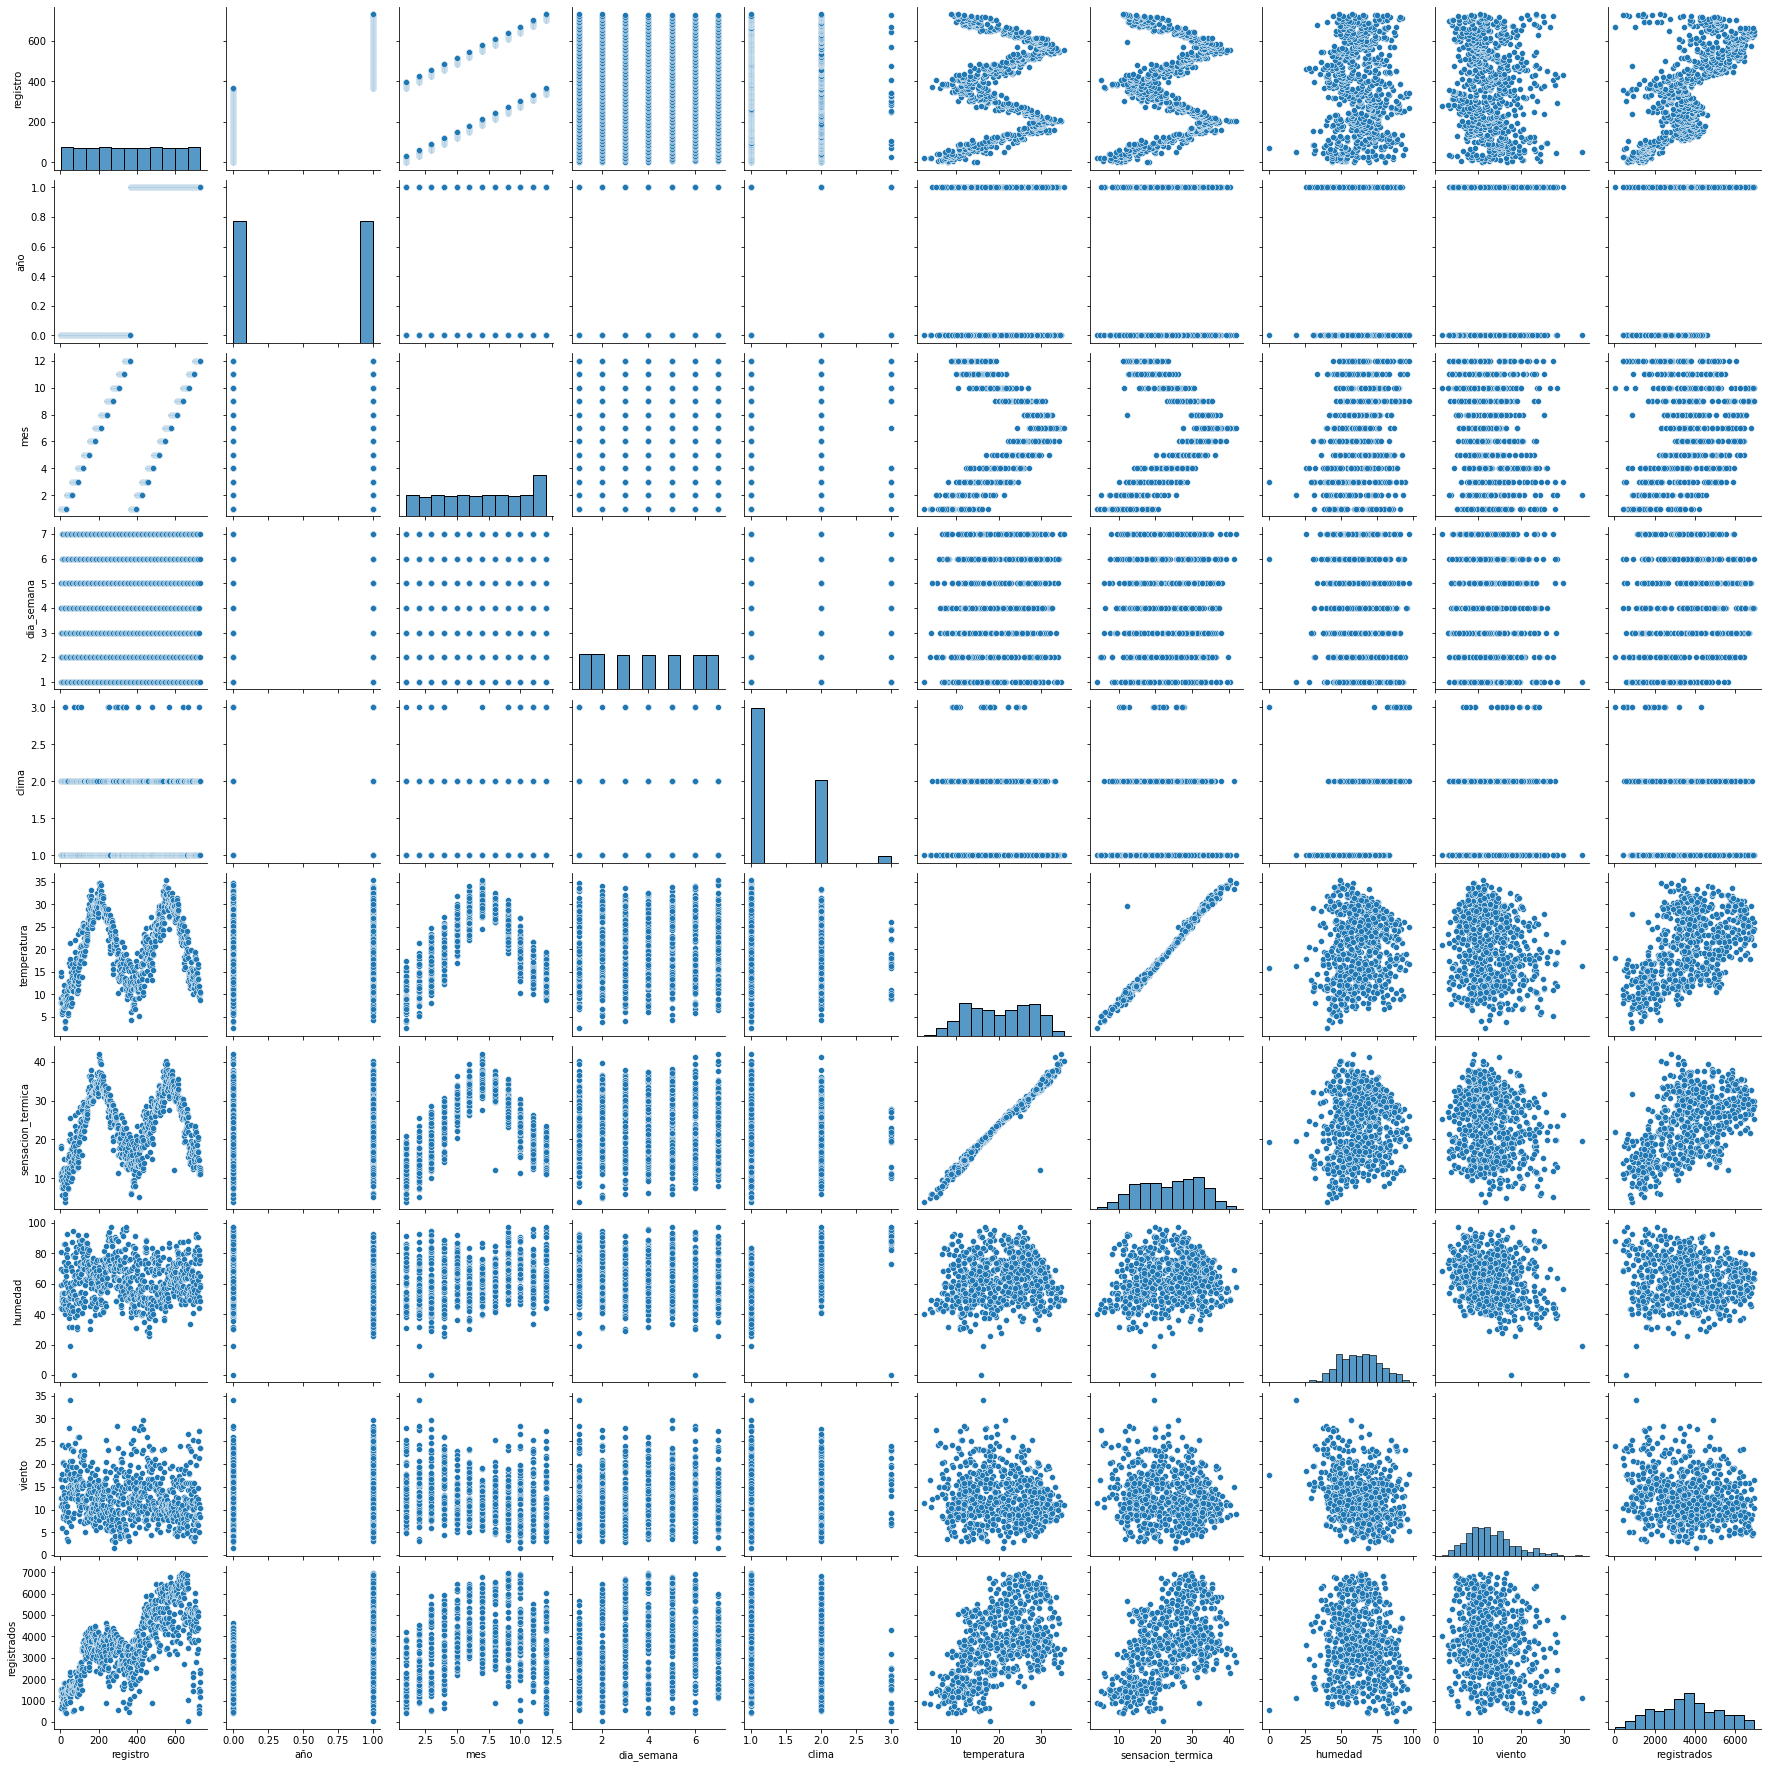

In [41]:
sns.pairplot(df)

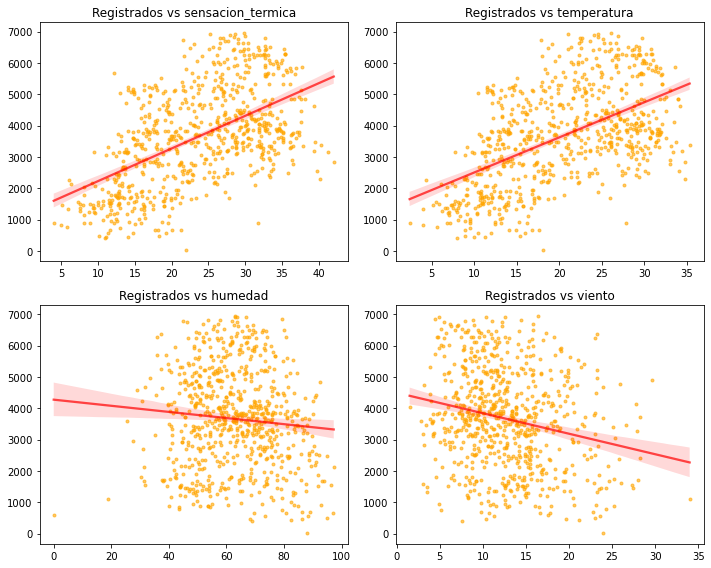

In [43]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 8))
axes = axes.flat
lista_columnas = ['sensacion_termica', 'temperatura', 'humedad', 'viento']
for i, colum in enumerate(lista_columnas):
    sns.regplot(
        x = df[colum],
        y = df["registrados"],
        color = "orange",
        marker = ".",
        scatter_kws = {"alpha": 0.6},
        line_kws = {"color": "red", "alpha": 0.7 },
        ax = axes[i])
    axes[i].set_title(f"Registrados vs {colum}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
fig.tight_layout();

In [44]:
#Variables que no nos aportan para nuestro modelo o que son redundantes, eliminamos
df.drop(["temperatura", "registro"], axis = 1, inplace = True)

In [45]:
df.to_csv("data/02_registrados_limpio.csv")